In [3]:
 !pip install rasterio
!apt-get install -y gdal-bin python-gdal python3-gdal


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 46.6 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package python-gdal is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source
However the following packages replace it:
  gdal-bin

E: Package 'python-gdal' has no installation candidate


In [4]:
import zipfile
import os

# Path to the zip file in Google Drive
zip_path = '/content/N28E079.SRTMGL1.hgt.zip'
unzip_dir = '/content/N28E079.SRTMGL1.hgt_data'

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

print("Unzipped files: ", os.listdir(unzip_dir))

Unzipped files:  ['N28E079.hgt']


File size: 25934402 bytes
Total values (int16): 12967201
Possible side length for a square grid: 3601
Using grid size: (3601, 3601)


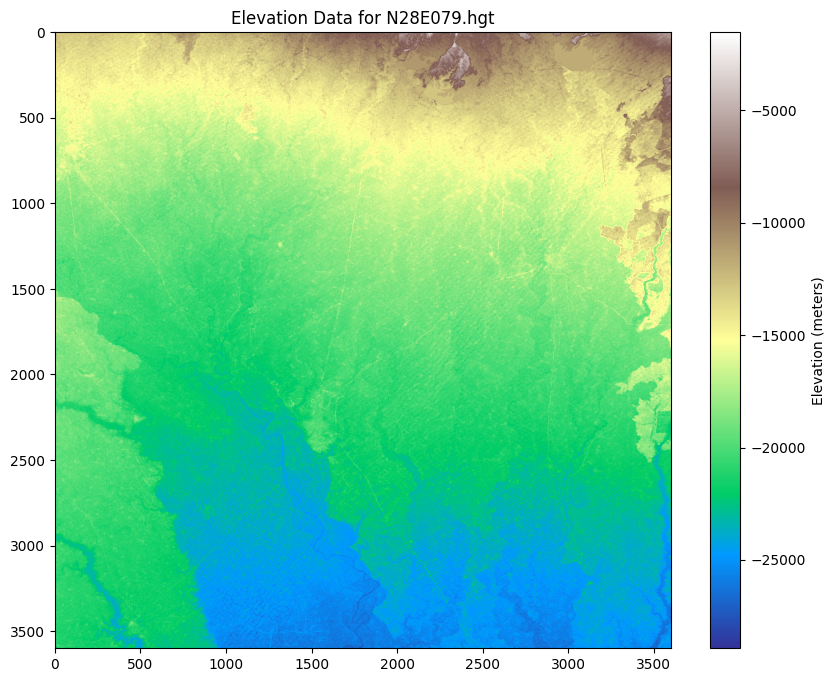

In [7]:
import os
hgt_file_path = "/content/N28E079.SRTMGL1.hgt_data/N28E079.hgt"
# Check the file size
file_size = os.path.getsize(hgt_file_path)

# Print file size and calculate expected grid size
print(f"File size: {file_size} bytes")

# Check if the size can be divided into a grid of int16 values (2 bytes each)
total_values = file_size // 2  # Since each int16 value takes 2 bytes
print(f"Total values (int16): {total_values}")

# Try to find the grid dimensions by taking the square root
side_length = int(np.sqrt(total_values))
print(f"Possible side length for a square grid: {side_length}")

# Adjust the grid size dynamically based on file contents
grid_size = (side_length, side_length)
print(f"Using grid size: {grid_size}")

# Now read the file and reshape based on the calculated grid size
with open(hgt_file_path, 'rb') as f:
    elevation_data = np.fromfile(f, np.int16).reshape(grid_size)

# Replace 'no data' values (-32768) with NaN
elevation_data = np.where(elevation_data == -32768, np.nan, elevation_data)

# Display the elevation data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(elevation_data, cmap='terrain')
plt.colorbar(label='Elevation (meters)')
plt.title(f'Elevation Data for {os.path.basename(hgt_file_path)}')
plt.show()


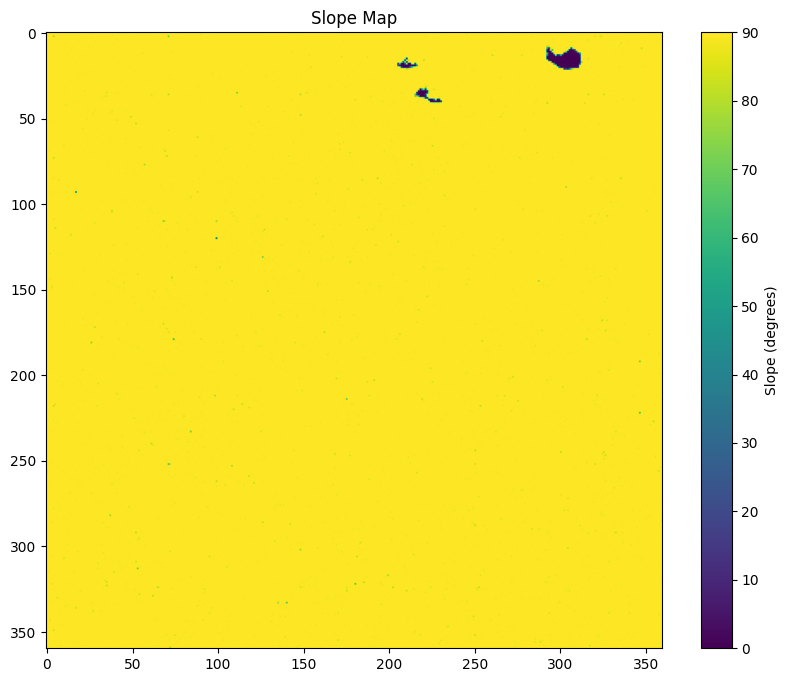

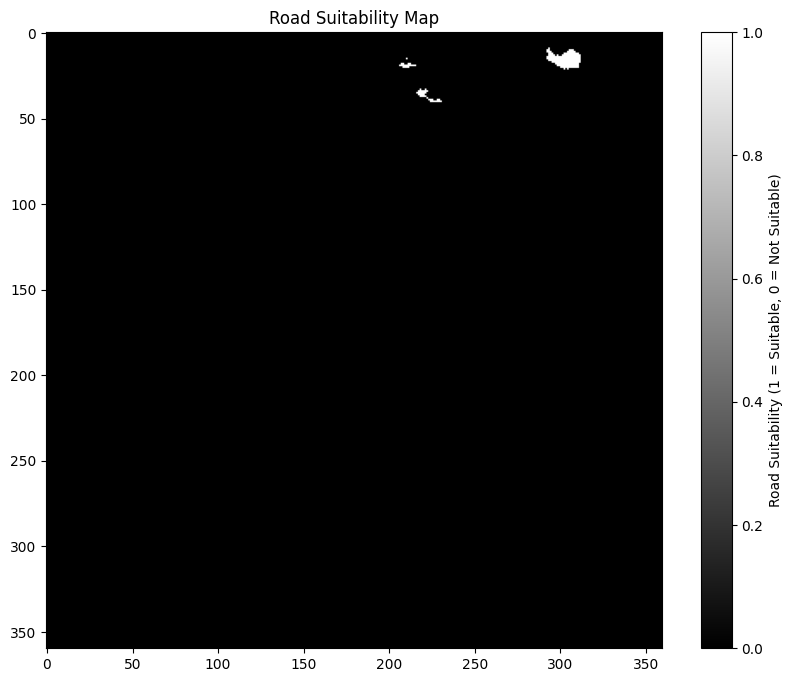

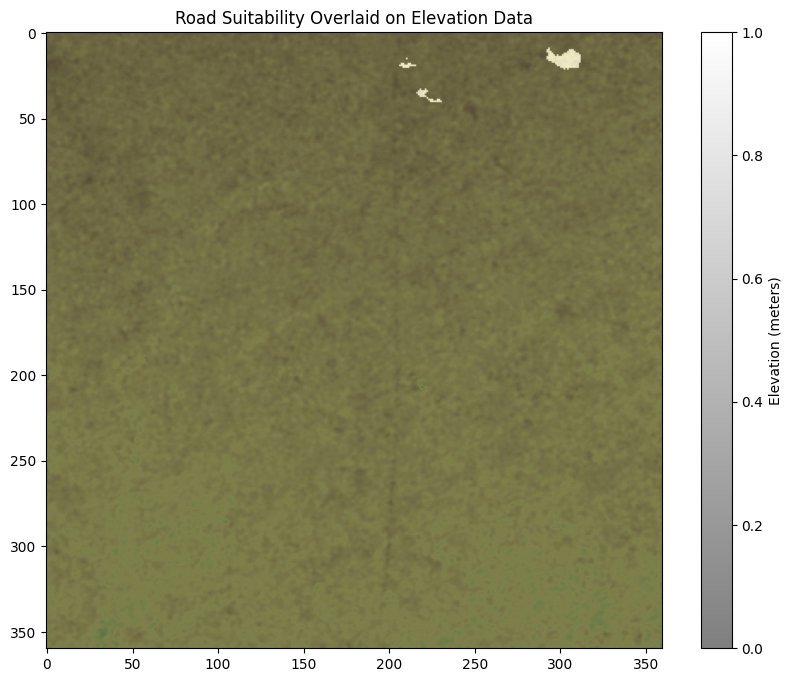

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

downsample_factor = 0.1  # This will downsample the data by 10% (adjust as needed)

# Downsample the elevation data
elevation_data_downsampled = zoom(elevation_data, downsample_factor)

# Calculate slope from the elevation data
dy, dx = np.gradient(elevation_data_downsampled)  # Gradient of the elevation in y and x directions
slope = np.sqrt(dx**2 + dy**2)        # Slope magnitude

# Convert slope to degrees (optional, but often used for easier interpretation)
slope_degrees = np.degrees(np.arctan(slope))

# Plot the slope map
plt.figure(figsize=(10, 8))
plt.imshow(slope_degrees, cmap='viridis', vmin=0, vmax=90)
plt.colorbar(label='Slope (degrees)')
plt.title('Slope Map')
plt.show()

# Define slope threshold for road suitability (e.g., less than 10 degrees)
road_suitability_threshold = 10

# Create a binary mask where slope is below the threshold (suitable for roads)
road_suitability = slope_degrees < road_suitability_threshold

# Plot the road suitability map
plt.figure(figsize=(10, 8))
plt.imshow(road_suitability, cmap='gray')  # Suitable areas will be white, unsuitable will be black
plt.colorbar(label='Road Suitability (1 = Suitable, 0 = Not Suitable)')
plt.title('Road Suitability Map')
plt.show()

# Optionally, overlay the suitability map onto the elevation data to better visualize
plt.figure(figsize=(10, 8))
plt.imshow(elevation_data, cmap='terrain')
plt.imshow(road_suitability, cmap='gray', alpha=0.5)  # Alpha for transparency
plt.colorbar(label='Elevation (meters)')
plt.title('Road Suitability Overlaid on Elevation Data')
plt.show()


CSV file saved to /content/analysis.csv


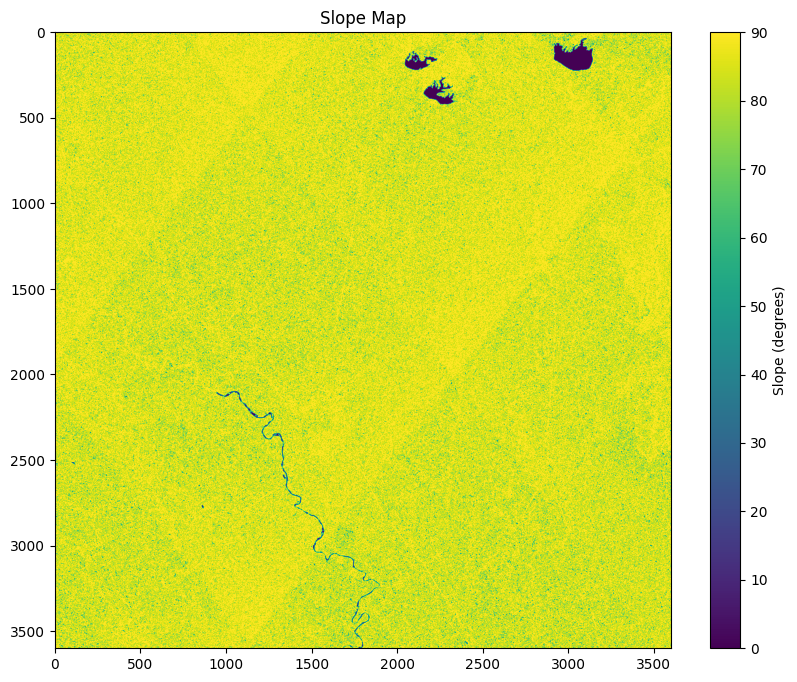

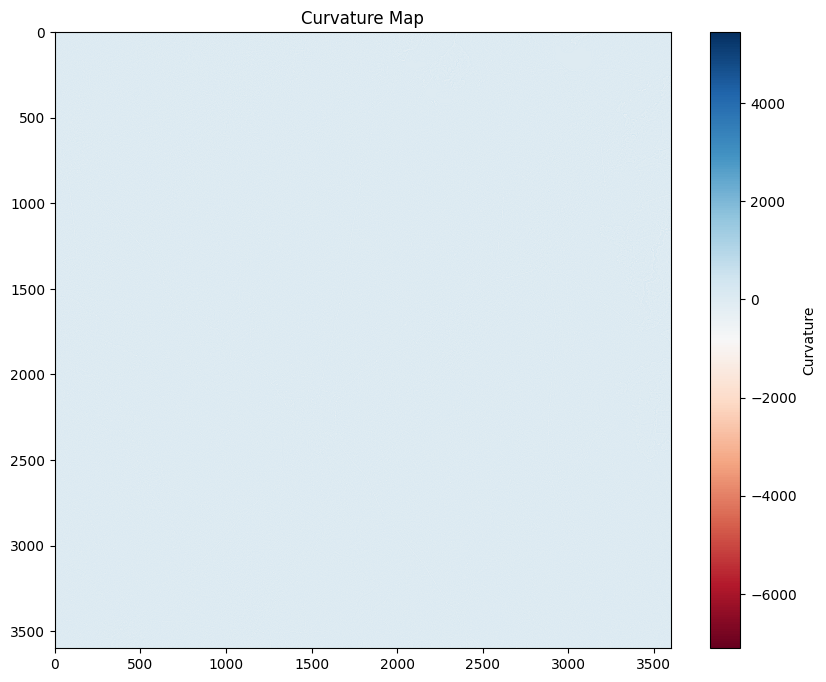

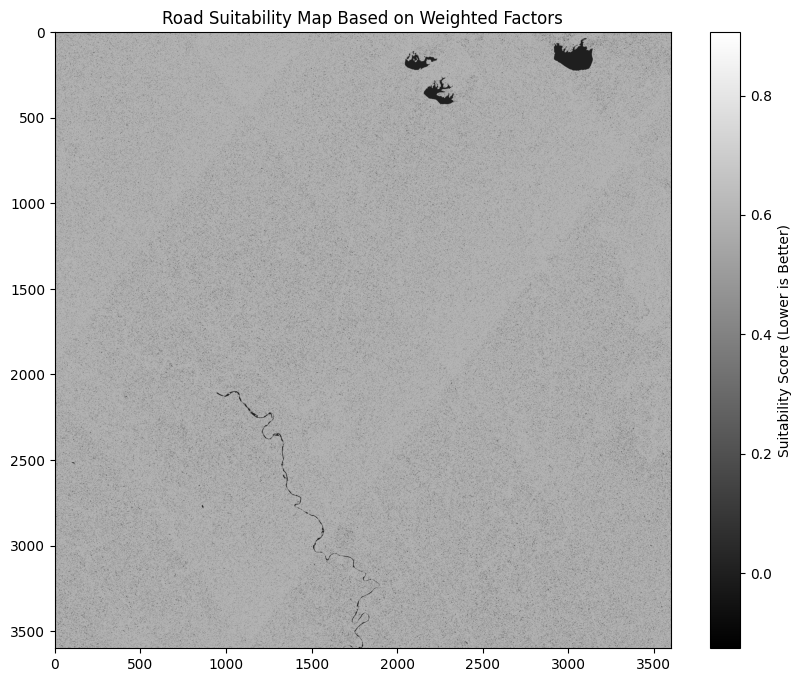

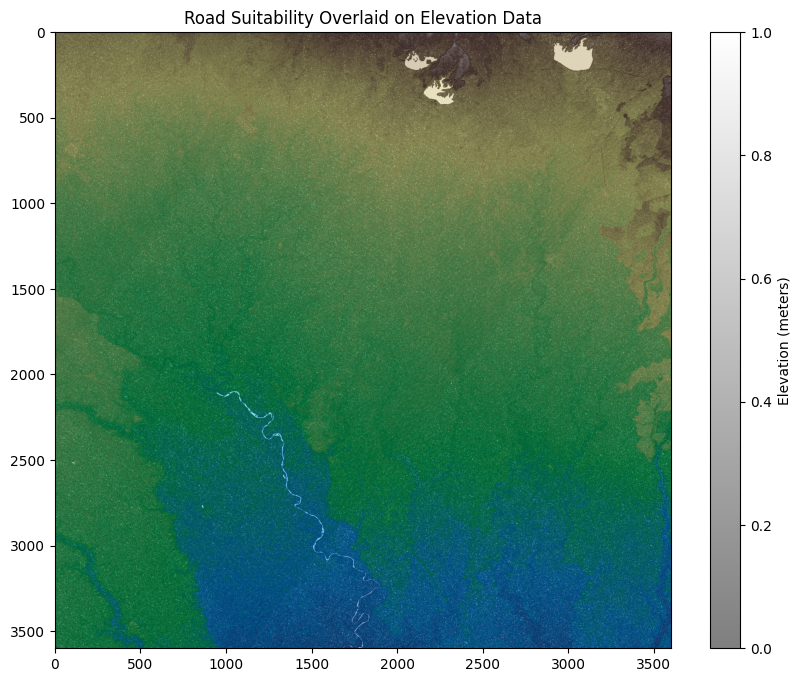

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def calculate_curvature(elevation_data):
    # Compute the first derivatives (gradients)
    dy, dx = np.gradient(elevation_data)

    # Compute the second derivatives (curvature) from the first derivatives
    d2y = np.gradient(dy, axis=0)  # Second derivative in the y-direction
    d2x = np.gradient(dx, axis=1)  # Second derivative in the x-direction

    # Combine second derivatives to get overall curvature
    curvature = d2x + d2y
    return curvature

# # Now you can call calculate_curvature as before
# curvature = calculate_curvature(elevation_data)

# Calculate slope from the elevation data
dy, dx = np.gradient(elevation_data)  # Gradient of the elevation in y and x directions
slope = np.sqrt(dx**2 + dy**2)        # Slope magnitude

# Convert slope to degrees for easier interpretation
slope_degrees = np.degrees(np.arctan(slope))

# Calculate curvature
curvature = calculate_curvature(elevation_data)

# Define slope threshold for road suitability (e.g., less than 10 degrees)
road_suitability_threshold = 10

# Create a binary mask where slope is below the threshold (suitable for roads)
road_suitability = slope_degrees < road_suitability_threshold

slope_weight = 0.6   # Slope is more important in road planning
curvature_weight = 0.4

# Normalize slope and curvature between 0 and 1 (so they can be weighted equally)
slope_normalized = slope_degrees / np.max(slope_degrees)
curvature_normalized = curvature / np.max(np.abs(curvature))

# Calculate the final road suitability score (lower is better)
suitability_score = slope_weight * slope_normalized + curvature_weight * curvature_normalized

# Export all data to a CSV file
rows, cols = elevation_data.shape
data_list = []

for i in range(rows):
    for j in range(cols):
        data_list.append([i, j, elevation_data[i, j], slope_degrees[i, j], curvature[i, j], road_suitability[i, j], suitability_score[i, j]])

# Create a pandas DataFrame
df = pd.DataFrame(data_list, columns=['Row', 'Col', 'Elevation (m)', 'Slope (degrees)', 'Curvature', 'Road Suitability', 'Suitability Score'])

# Save the DataFrame to a CSV file
csv_file_path = '/content/analysis.csv'
df.to_csv(csv_file_path, index=False)

print(f"CSV file saved to {csv_file_path}")

# Plot the slope map
plt.figure(figsize=(10, 8))
plt.imshow(slope_degrees, cmap='viridis', vmin=0, vmax=90)
plt.colorbar(label='Slope (degrees)')
plt.title('Slope Map')
plt.show()

# Plot the curvature map
plt.figure(figsize=(10, 8))
plt.imshow(curvature, cmap='RdBu')
plt.colorbar(label='Curvature')
plt.title('Curvature Map')
plt.show()

# Plot the road suitability map
plt.figure(figsize=(10, 8))
plt.imshow(suitability_score, cmap='gray')  # Lower suitability scores indicate more suitable areas
plt.colorbar(label='Suitability Score (Lower is Better)')
plt.title('Road Suitability Map Based on Weighted Factors')
plt.show()

# Optionally, overlay the suitability map onto the elevation data
plt.figure(figsize=(10, 8))
plt.imshow(elevation_data, cmap='terrain')
plt.imshow(road_suitability, cmap='gray', alpha=0.5)  # Alpha for transparency
plt.colorbar(label='Elevation (meters)')
plt.title('Road Suitability Overlaid on Elevation Data')
plt.show()


In [ ]:
from google.colab import files

# Download the CSV file
files.download(csv_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df.head()

Row  Col  Elevation (m)  Slope (degrees)  Curvature  Road Suitability  \
0    0    0       -13312.0        89.776189        0.0             False   
1    0    1       -13312.0         0.000000      320.0              True   
2    0    2       -13312.0        89.799818      512.0             False   
3    0    3       -13056.0        89.841742       64.0             False   
4    0    4       -12800.0        89.776189      -64.0             False   

   Suitability Score  
0           0.598595  
1           0.018018  
2           0.627582  
3           0.602636  
4           0.594992